# Описание проекта   
Для увеличения выручки в крупном интернет-магазина аналитик совместно с отделом маркетинга подготовили список гипотез.   

**Исходные данные:**
- Гипотезы
- Данные о заказах
- данные о посетителях

**Цель** Приоритизировать гипотезы, запустить A/B-тест и проанализировать результаты. 

In [1]:
# импортируем библиотеку обработки и анализа структурированных данных
import pandas as pd
pd.set_option('display.max_colwidth', None)

# импортируем библиотеку для визуализации данных двумерной и трёхмерной графикой
import matplotlib.pyplot as plt

# импортируем библиотеку математических вычислений
import numpy as np

# импортируем модуль для работы с датой и временем
import datetime as dt

# импортируем статистические функции
import scipy.stats as stats

In [2]:
hypothesis = pd.read_csv('https://code.s3.yandex.net/datasets/hypothesis.csv')
orders = pd.read_csv('https://code.s3.yandex.net/datasets/orders.csv', parse_dates=['date'])
visitors = pd.read_csv('https://code.s3.yandex.net/datasets/visitors.csv', parse_dates=['date'])

Нам удалось преобразовать столбец date в нужный нам тип «datetime64[ns]», но в то же время появилась новая проблема. Часть данных преобразовалась в формат “гггг-дд-мм”. Чтобы этого избежать и привести наши даты в формат “гггг-мм-дд” при импорте необходимо дополнительно передать аргумент «dayfirst» со значением «True»:


[Ссылка на статью](https://habr.com/ru/company/ruvds/blog/574352/)

`df = pd.read_csv('data.csv' ,parse_dates=['date'], dayfirst=True)`

### Выполним предобработку данных

Файл **hypothesis**

In [3]:
hypothesis.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Hypothesis  9 non-null      object
 1   Reach       9 non-null      int64 
 2   Impact      9 non-null      int64 
 3   Confidence  9 non-null      int64 
 4   Efforts     9 non-null      int64 
dtypes: int64(4), object(1)
memory usage: 488.0+ bytes


In [4]:
# Приведём название колонок к нижнему регистру
hypothesis.columns = hypothesis.columns.str.lower()

In [5]:
hypothesis

,hypothesis,reach,impact,confidence,efforts
0,"Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей",3,10,8,6
1,"Запустить собственную службу доставки, что сократит срок доставки заказов",2,5,4,10
2,"Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа",8,3,7,3
3,"Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар",8,3,3,8
4,"Изменить цвет фона главной страницы, чтобы увеличить вовлеченность пользователей",3,1,1,1
5,"Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов",3,2,2,3
6,"Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию",5,3,8,3
7,"Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок",10,7,8,5
8,"Запустить акцию, дающую скидку на товар в день рождения",1,9,9,5


Типы данных установлены корректно. Дубликатов нет   
Содержание таблицы:
- `Hypothesis` — краткое описание гипотезы;
- `Reach` — охват пользователей по 10-балльной шкале;
- `Impact` — влияние на пользователей по 10-балльной шкале;
- `Confidence` — уверенность в гипотезе по 10-балльной шкале;
- `Efforts` — затраты ресурсов на проверку гипотезы по 10-балльной шкале. Чем больше значение Efforts, тем дороже проверка гипотезы.

Файл **orders**

In [6]:
orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   transactionId  1197 non-null   int64         
 1   visitorId      1197 non-null   int64         
 2   date           1197 non-null   datetime64[ns]
 3   revenue        1197 non-null   int64         
 4   group          1197 non-null   object        
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 46.9+ KB


In [7]:
# Приведём название колонок к змеиному регистру
orders.columns = ['transaction_id', 'visitor_id', 'date', 'revenue', 'group']

In [8]:
print('Полных дубликатов =', orders.duplicated().sum())

Полных дубликатов = 0


In [9]:
orders.head(2)

,transaction_id,visitor_id,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B


Для колонок установили нужный тип данных. Дубликатов нет   
Содержание таблицы:
- `transaction_id` — идентификатор заказа;
- `visitor_id` — идентификатор пользователя, совершившего заказ;
- `date` — дата, когда был совершён заказ;
- `revenue` — выручка заказа;
- `group` — группа A/B-теста, в которую попал заказ.

Файл **visitors**

In [10]:
visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   date      62 non-null     datetime64[ns]
 1   group     62 non-null     object        
 2   visitors  62 non-null     int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 1.6+ KB


In [11]:
print('Полных дубликатов =', visitors.duplicated().sum())

Полных дубликатов = 0


In [12]:
visitors.head(2)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619


Наименование столбцов корретно. Тип данны заменён. Дубликатов нет.   
Содержание таблицы:
- `date` — дата;
- `group` — группа A/B-теста;
- `visitors` — количество пользователей в указанную дату в указанной группе A/B-теста

In [13]:
print('Количество групп в АВ-тесте в датафрейме orders -', len(orders.group.unique()))
print('Количество групп в АВ-тесте в датафрейме visitors -', len(visitors.group.unique()))
print()
print('min дата журнала заказов', orders['date'].min())
print('max дата журнала заказов', orders['date'].max())
print()
print('min дата журнала визитов', visitors['date'].min())
print('max дата журнала визитов', visitors['date'].max())
print()
print('Количество пользователей в группе А -', len(orders.query('group=="A"')['visitor_id'].unique()))
print('Количество пользователей в группе B -', len(orders.query('group=="B"')['visitor_id'].unique()))
print()
print('Кол-во посещений группы А', visitors.query('group=="A"')['visitors'].sum())
print('Кол-во посещений группы B', visitors.query('group=="B"')['visitors'].sum())

Количество групп в АВ-тесте в датафрейме orders - 2
Количество групп в АВ-тесте в датафрейме visitors - 2

min дата журнала заказов 2019-08-01 00:00:00
max дата журнала заказов 2019-08-31 00:00:00

min дата журнала визитов 2019-08-01 00:00:00
max дата журнала визитов 2019-08-31 00:00:00

Количество пользователей в группе А - 503
Количество пользователей в группе B - 586

Кол-во посещений группы А 18736
Кол-во посещений группы B 18916


In [14]:
groups = (
        orders.groupby('visitor_id') \
        .agg({'group': 'nunique'}) \
        .reset_index() \
        .query('group != 1')
)
print('Количество пользователей попавших в обе группы -', len(groups))

Количество пользователей попавших в обе группы - 58


## 1 Приоритизация гипотез.   

В файле `/datasets/hypothesis.csv` 9 гипотез по увеличению выручки интернет-магазина с указанными параметрами `Reach`, `Impact`, `Confidence`, `Effort`.

### 1.1 Примените фреймворк ICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

Фреймворк ICE отражает взияние гипотезы


отразим формулу с помощью инструмента LaTex
<br>

$$ICE = \frac{Impact * Confidence}{Efforts}$$

$$RICE = \frac{Rearch * Impact * Confidence}{Efforts}$$
</div>

In [15]:
# Вычислим произведение влияние на пользователей и уверенность в гипотезе.
# Результат разделим на затраты ресурсов на проверку гипотезы
hypothesis['ICE'] = (hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']

print(hypothesis[['hypothesis', 'ICE']].sort_values(by='ICE', ascending=False))

                                                                                                     hypothesis  \
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позволит увеличить количество заказов   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользоват

Наиболее перспективные гипотезы по ICE:
- Запустить акцию, дающую скидку на товар в день рождения
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок

### 1.2 Примените фреймворк RICE для приоритизации гипотез. Отсортируйте их по убыванию приоритета.

In [16]:
# Добавим в числитель охват пользователей
hypothesis['RICE'] = (hypothesis['reach'] * hypothesis['impact'] * hypothesis['confidence']) / hypothesis['efforts']
print(hypothesis[['hypothesis', 'RICE']].sort_values(by='RICE', ascending=False))

                                                                                                     hypothesis  \
7              Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок   
2  Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа   
0            Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей   
6          Показать на главной странице баннеры с актуальными акциями и распродажами, чтобы увеличить конверсию   
8                                                       Запустить акцию, дающую скидку на товар в день рождения   
3           Изменить структура категорий, что увеличит конверсию, т.к. пользователи быстрее найдут нужный товар   
1                                     Запустить собственную службу доставки, что сократит срок доставки заказов   
5                      Добавить страницу отзывов клиентов о магазине, что позвол

Наиболее перспективные гипотезы по RICE:
- Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок
- Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа
- Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей

### 1.3 Укажите, как изменилась приоритизация гипотез при применении RICE вместо ICE. Объясните, почему так произошло.

В случае применения фреймворка ICE лидерами были гипотезы с индексом N8 (*Запустить акцию, дающую скидку на товар в день рождения*) и N0 (*Добавить два новых канала привлечения трафика, что позволит привлекать на 30% больше пользователей*). Однако, имея низкий балл по охвату пользователей после применения RICE влияние гипотезы снизилось. Лидерами RICE стали гипотезы с индексом N7 (*Добавить форму подписки на все основные страницы, чтобы собрать базу клиентов для email-рассылок*) и N2 (*Добавить блоки рекомендаций товаров на сайт интернет магазина, чтобы повысить конверсию и средний чек заказа*), имеющие высокий охват пользователей.

Визуализируем отношение ICE и RICE на графике.

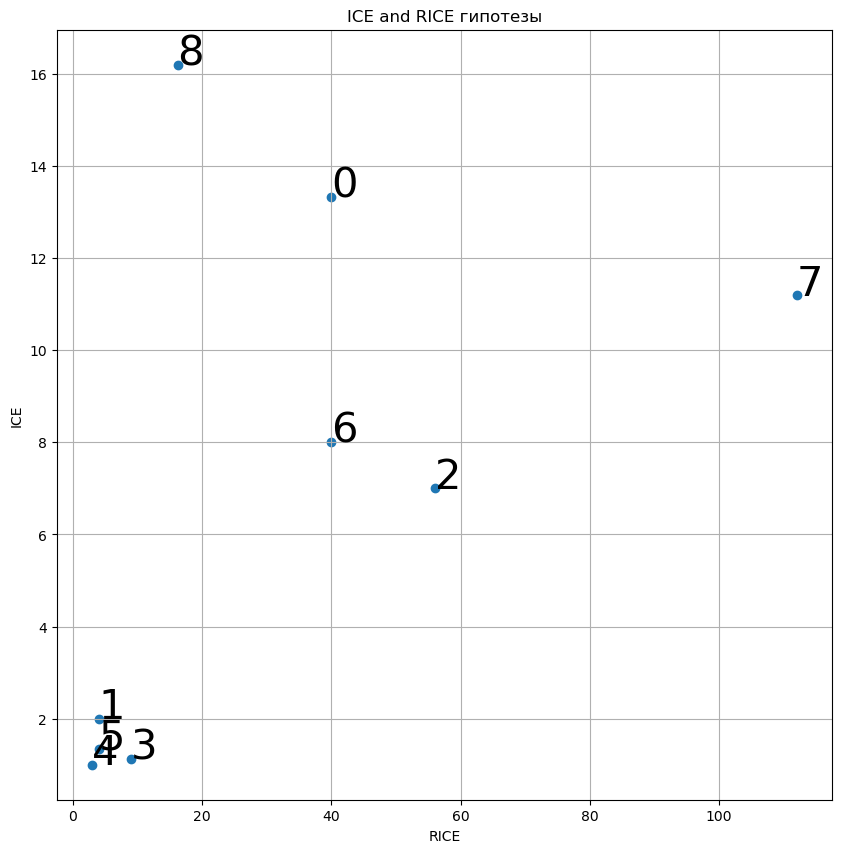

In [17]:
y = hypothesis['ICE'] 
z = hypothesis['RICE'] 
n = hypothesis.index 

fig, ax = plt.subplots()
ax.scatter(z, y)

for i, txt in enumerate(n):
    ax.annotate(txt, (z[i], y[i]), size=30)

plt.title("ICE and RICE гипотезы") 
plt.xlabel("RICE") 
plt.ylabel("ICE")
plt.grid()

fig.set_figheight(10)
fig.set_figwidth(10) 
plt.show()  

## 2 Анализ A/B-теста

Результат A/B-теста описан в переменных `orders` и `visitors`

### 2.1 Постройте график кумулятивной выручки по группам. Сделайте выводы и предположения.

In [18]:
# создаем массив уникальных пар значений дат и групп теста
datesGroups = orders[['date','group']].drop_duplicates()

# получаем агрегированные кумулятивные по дням данные о заказах 
ordersAggregated = (
    datesGroups
    .apply(lambda x: orders[np.logical_and(orders['date'] <= x['date'], orders['group'] == x['group'])]
           .agg({'date' : 'max', 
                 'group' : 'max', 
                 'transaction_id' : 'nunique', 
                 'visitor_id' : 'nunique', 
                 'revenue' : 'sum'}), axis=1)
            .sort_values(by=['date','group'])
)

# получаем агрегированные кумулятивные по дням данные о посетителях интернет-магазина 
visitorsAggregated = (
    datesGroups.apply(lambda x: visitors[np.logical_and(visitors['date'] <= x['date'], visitors['group'] == x['group'])]
        .agg({'date' : 'max', 
              'group' : 'max', 
              'visitors' : 'sum'}), axis=1)
        .sort_values(by=['date','group'])
)

# объединяем кумулятивные данные в одной таблице и присваиваем ее столбцам понятные названия
cumulativeData = ordersAggregated.merge(visitorsAggregated, left_on=['date', 'group'], right_on=['date', 'group'])

# переименуем столбцы
cumulativeData.columns = ['date', 'group', 'orders', 'buyers', 'revenue', 'visitors']

print(cumulativeData.head(5)) 

        date group  orders  buyers  revenue  visitors
0 2019-08-01     A      24      20   148579       719
1 2019-08-01     B      21      20   101217       713
2 2019-08-02     A      44      38   242401      1338
3 2019-08-02     B      45      43   266748      1294
4 2019-08-03     A      68      62   354874      1845


Ранее мы опредилили даты начала и окончания тестирования. Проверим, корректно ли был создан датафрейм cumulativeData. Даты должны быть в диаазоне от 2019-08-01 до 2019-08-31.

In [19]:
print(cumulativeData['date'].min())
print(cumulativeData['date'].max())   

2019-08-01 00:00:00
2019-08-31 00:00:00


Получили таблицу `cumulativeData` с кумулятивными данными.   
Содержание таблицы:
- `date` — дата;
- `group` — группа A/B-теста (A или B);
- `orders` — кумулятивное количество заказов на указанную дату в указанной группе;
- `buyers` — кумулятивное количество пользователей, совершивших хотя бы один заказ, на указанную дату в указанной группе;
- `revenue` — кумулятивная выручка на указанную дату в указанной группе (средний чек);
- `visitors` — кумулятивное количество посетителей интернет-магазина на указанную дату в определённой группе.

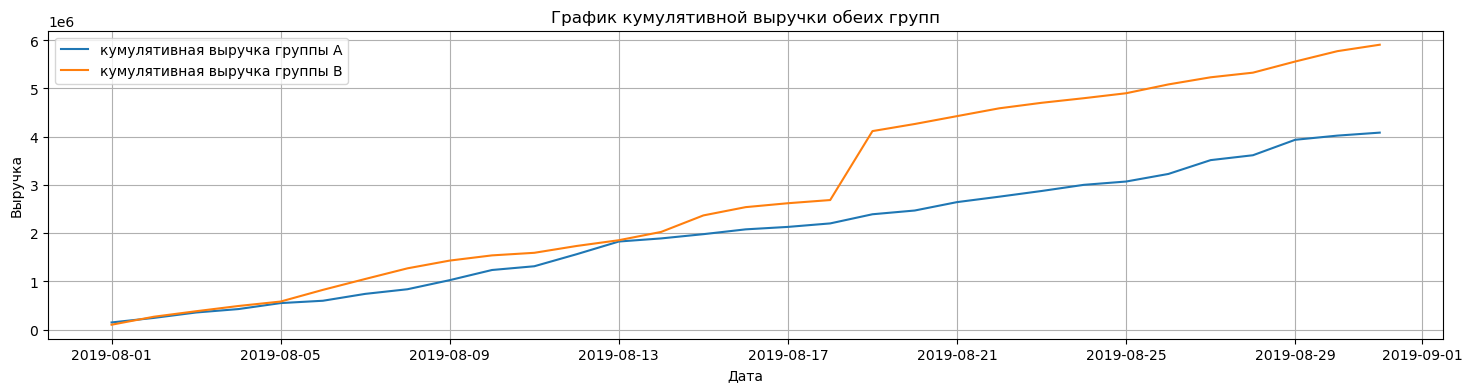

In [20]:
# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = cumulativeData[cumulativeData['group']=='A'][['date','revenue', 'orders']]

# датафрейм с кумулятивным количеством заказов и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = cumulativeData[cumulativeData['group']=='B'][['date','revenue', 'orders']]

# установим размер графика
plt.figure(figsize=(18,4))


# Строим график выручки группы А
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue'], label='кумулятивная выручка группы A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue'], label='кумулятивная выручка группы B')

plt.grid()
plt.legend();
plt.title('График кумулятивной выручки обеих групп')    
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.show()

Выручка группы **А** показывает равномерный, линейный рост.   
Подобное можно наблюдать у группы **В**. Однако, с 17 по 21 августа присутствует резкий рост. Причиной может быть увеличение покупательной активности или очень дорогой заказ.    
Посмотрим, что дало резкий рост.

In [21]:
# Методом describe посмотрим распределение выручки
orders['revenue'].describe()

count    1.197000e+03
mean     8.348006e+03
std      3.919113e+04
min      5.000000e+01
25%      1.220000e+03
50%      2.978000e+03
75%      8.290000e+03
max      1.294500e+06
Name: revenue, dtype: float64

Медианный чек ~ 3000. Среднее значение выше 3-го квантиля. А максимальное значение 1.2 млн.

In [22]:
# выручка с 17 по 21 августа
orders.query('"2019-08-17" < date < "2019-08-21" ').sort_values(by='revenue', ascending=False).head()

,transaction_id,visitor_id,date,revenue,group
425,590470918,1920142716,2019-08-19,1294500,B
530,3970235543,2912540959,2019-08-19,43990,A
751,348143148,689129267,2019-08-20,37150,B
527,1570513684,2837914161,2019-08-19,33405,B
421,3765974140,1357170471,2019-08-19,31680,A


19 августа оформлена самая дорогая покупка.

Text(0.5, 1.0, 'Диаграмма рассеяния для выручки за весь период')

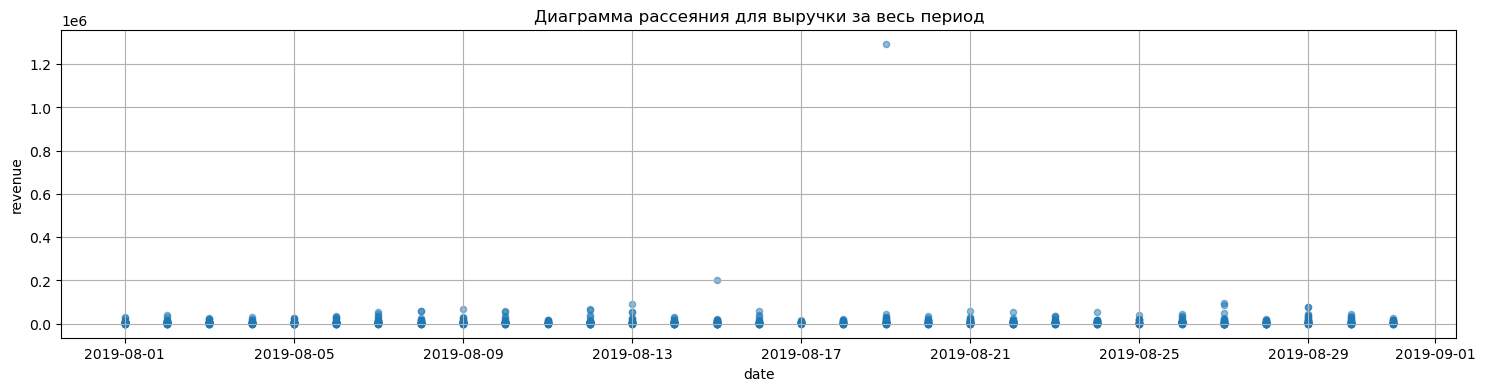

In [23]:
# Построим диаграмму рассеяния для выручки за весь период
orders.plot(x='date', y='revenue', kind='scatter', alpha=0.5, figsize=(18,4), grid=True);
plt.title('Диаграмма рассеяния для выручки за весь период')

Диаграмма рассеяния отражает самую дорогую покупку 19 августа и ещё одну покупку с высокой выручкой - 15 августа.   
На графике комулятивной выручки выдно, что группа **А** и **В** имеют однинаковый показатель на 13 августа. 15 августа группа **В** показывает рост. Посмотрим самую дорогую покупку в этот день, она должна быть совершена пользователем из группв **В**.

In [24]:
# выручка за 15 августа
orders.query('date == "2019-08-15" ').sort_values(by='revenue', ascending=False).head(1)

,transaction_id,visitor_id,date,revenue,group
1196,3936777065,2108080724,2019-08-15,202740,B


Всё верно, 202 тыс. - значительная выручка. Покупатель из группы **В**.

### 2.2 Постройте график кумулятивного среднего чека по группам. Сделайте выводы и предположения.

`cumulativeRevenue['revenue']` - кумулятивная выручка   
`cumulativeRevenueB['orders']` - кумулятивное число заказов

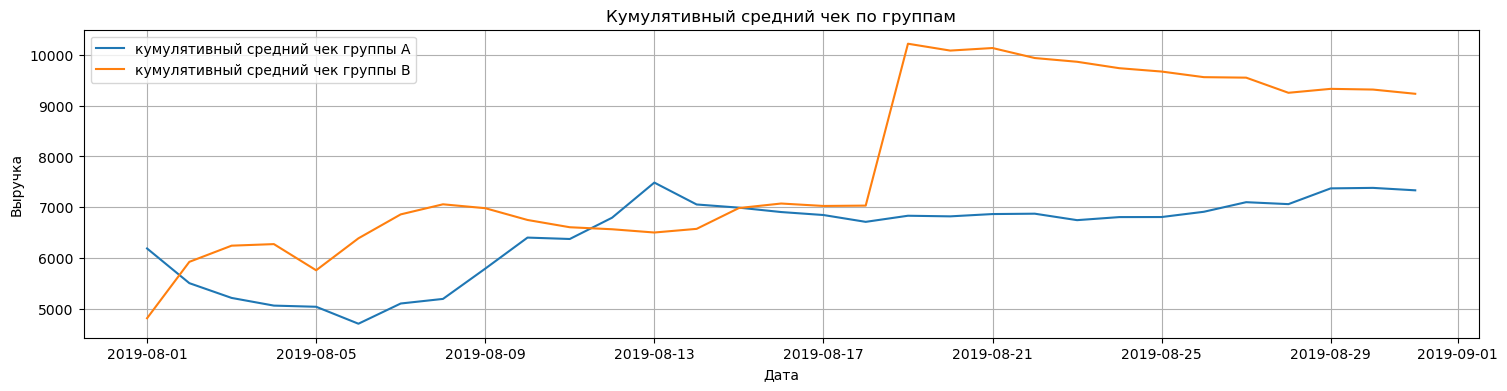

In [25]:
# зададим размер графика
plt.figure(figsize=(18,4))

# разделим кумулятивную выручку на кумулятивное число заказов
plt.plot(cumulativeRevenueA['date'], cumulativeRevenueA['revenue']/
         cumulativeRevenueA['orders'], label='кумулятивный средний чек группы A')
plt.plot(cumulativeRevenueB['date'], cumulativeRevenueB['revenue']/
         cumulativeRevenueB['orders'], label='кумулятивный средний чек группы B')
plt.grid()
plt.title('Кумулятивный средний чек по группам')
plt.xlabel('Дата')
plt.ylabel('Выручка')
plt.legend();

В начале месяца у группы **А** были дешевые заказы. Средний чек группы стал равномерным с 15 августа, демонстрируя небольшое увеличение в конце месяца.   
Дорогой заказ существенно повляел на расчёт кумулятивного среднего чека для группы **В**. Однако начиная с 20 августа видим ежедневное снижение стоимости кумулятивного среднего чека в группе.

### 2.3 Постройте график относительного изменения кумулятивного среднего чека группы B к группе A. Сделайте выводы и предположения.

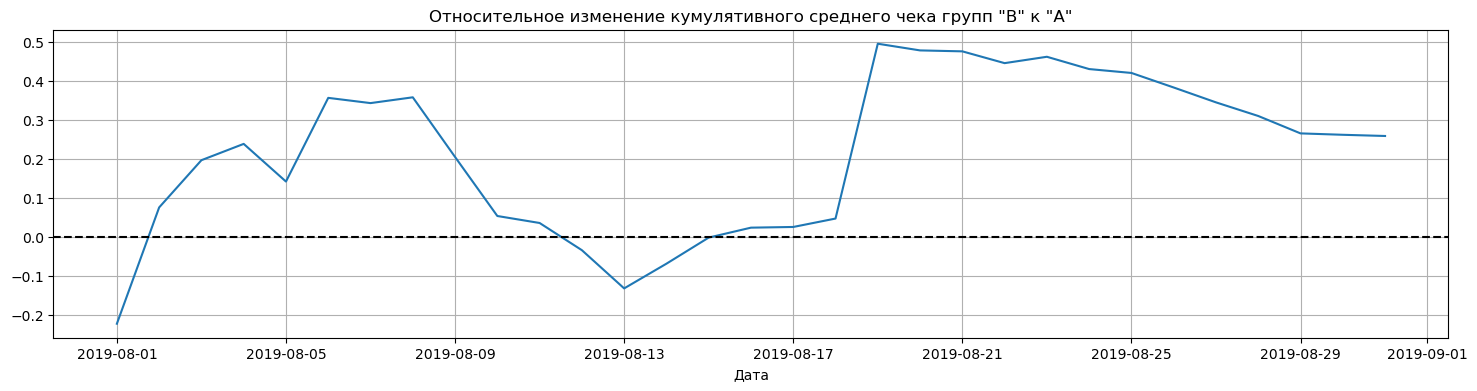

In [26]:
# собираем данные в одном датафрейме
mergedCumulativeRevenue = (
    cumulativeRevenueA.
    merge(cumulativeRevenueB, left_on='date', right_on='date', how='left', suffixes=['A', 'B']))

# зададим размер графика
plt.figure(figsize=(18,4))

# cтроим отношение средних чеков
plt.plot(mergedCumulativeRevenue['date'], (mergedCumulativeRevenue['revenueB']/
                                           mergedCumulativeRevenue['ordersB'])/
                                          (mergedCumulativeRevenue['revenueA']/
                                           mergedCumulativeRevenue['ordersA'])-1)

plt.grid()
plt.title('Относительное изменение кумулятивного среднего чека групп "B" к "А"')
plt.xlabel('Дата')
# добавляем ось X
plt.axhline(y=0, color='black', linestyle='--');

Цель графика - показать временные периоды, в которые кумулятивные средний чек группы **B** выше среднего чека группы **A**, а так же выявить наличие аномальных значений. 

### 2.4 Постройте график кумулятивного среднего количества заказов по группам. Сделайте выводы и предположения.

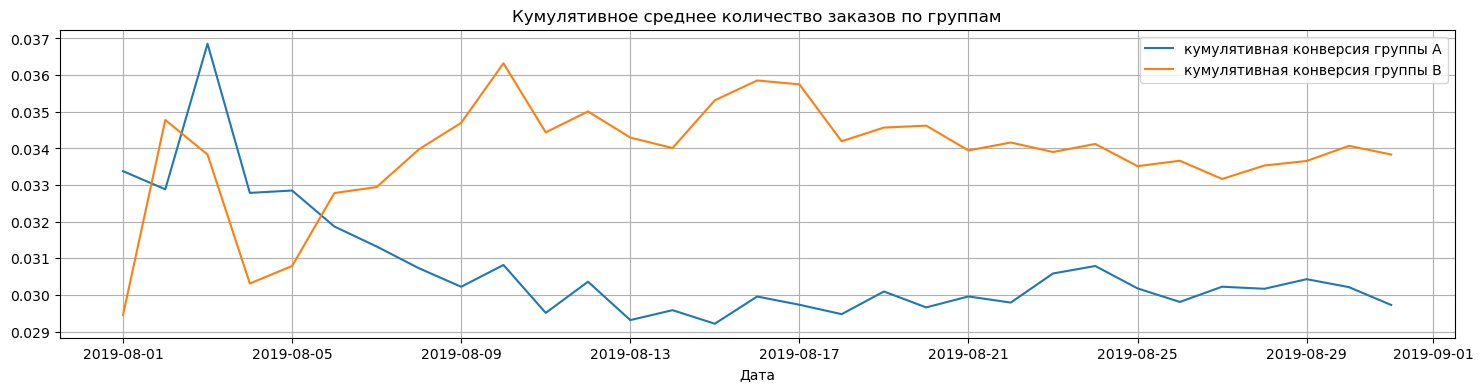

In [27]:
# считаем кумулятивную конверсию
cumulativeData['conversion'] = cumulativeData['orders']/cumulativeData['visitors']

# отделяем данные по группе A
cumulativeDataA = cumulativeData[cumulativeData['group']=='A']

# отделяем данные по группе B
cumulativeDataB = cumulativeData[cumulativeData['group']=='B']

# зададим размер графика
plt.figure(figsize=(18,4))

# строим графики
plt.plot(cumulativeDataA['date'], cumulativeDataA['conversion'], label='кумулятивная конверсия группы A')
plt.plot(cumulativeDataB['date'], cumulativeDataB['conversion'], label='кумулятивная конверсия группы B')

plt.grid() # сетка
plt.title('Кумулятивное среднее количество заказов по группам') # название
plt.xlabel('Дата') # подпись оси х
plt.legend(); # легенда

# задаем масштаб осей
#plt.axis(["2019-04-01", '2019-04-23', 0, 0.015]) 

В начале теста конверсия колебалась у обеих групп. Начиная и 4 августа группа **В** показала рост и зафиксировала до конца месяца значение в диапазоне от 0.033 до 0.036.   
5 августа группа **А** показала падение и зафиксировалась в диапазоне от 0.029 до 0.031.

### 2.5 Постройте график относительного изменения кумулятивного среднего количества заказов группы B к группе A. Сделайте выводы и предположения.

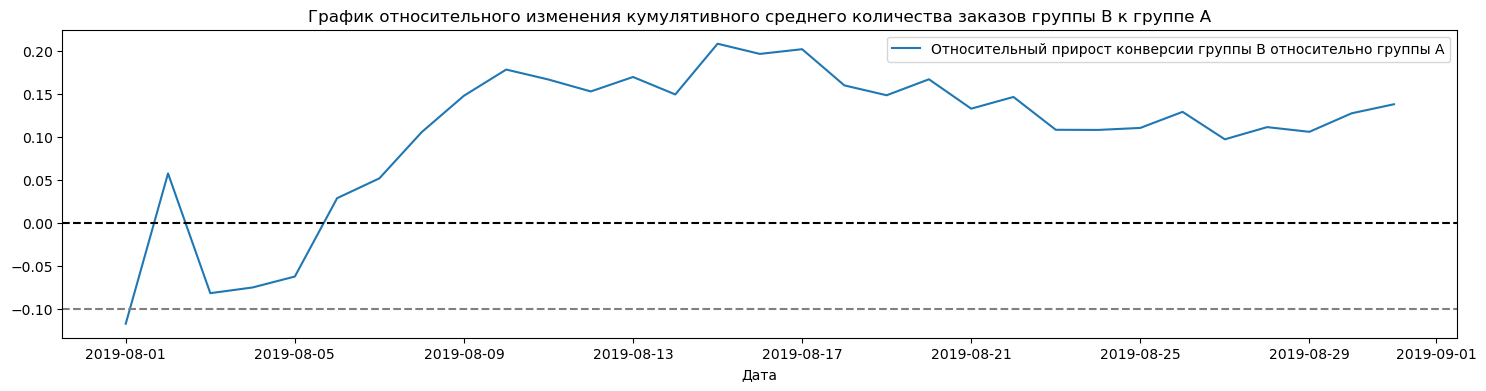

In [28]:
mergedCumulativeConversions = (
    cumulativeDataA[['date','conversion']]
    .merge(cumulativeDataB[['date','conversion']], left_on='date', right_on='date', how='left', suffixes=['A', 'B'])
)

# зададим размер графика
plt.figure(figsize=(18,4))

plt.plot(mergedCumulativeConversions['date'], mergedCumulativeConversions['conversionB']/
         mergedCumulativeConversions['conversionA']-1, label="Относительный прирост конверсии группы B относительно группы A")
plt.legend()

plt.title('График относительного изменения кумулятивного среднего количества заказов группы B к группе A')
plt.xlabel('Дата')
plt.axhline(y=0, color='black', linestyle='--')
plt.axhline(y=-0.1, color='grey', linestyle='--');
#plt.axis(["2019-04-01", '2019-04-23', -0.6, 0.6]) 

В начале месяца видим колебание конверсии для группы **В**. Начиная с 5 августа группа показала рост и далее сохранила лидерство до конца месяца.

### 2.6 Постройте точечный график количества заказов по пользователям. Сделайте выводы и предположения.

In [29]:
# создадим переменную с числом заказов у каджого покупателя
purchase = orders.groupby('visitor_id', as_index=False) \
           .agg({'transaction_id': 'nunique'}) \
           .sort_values(by='transaction_id', ascending=False)

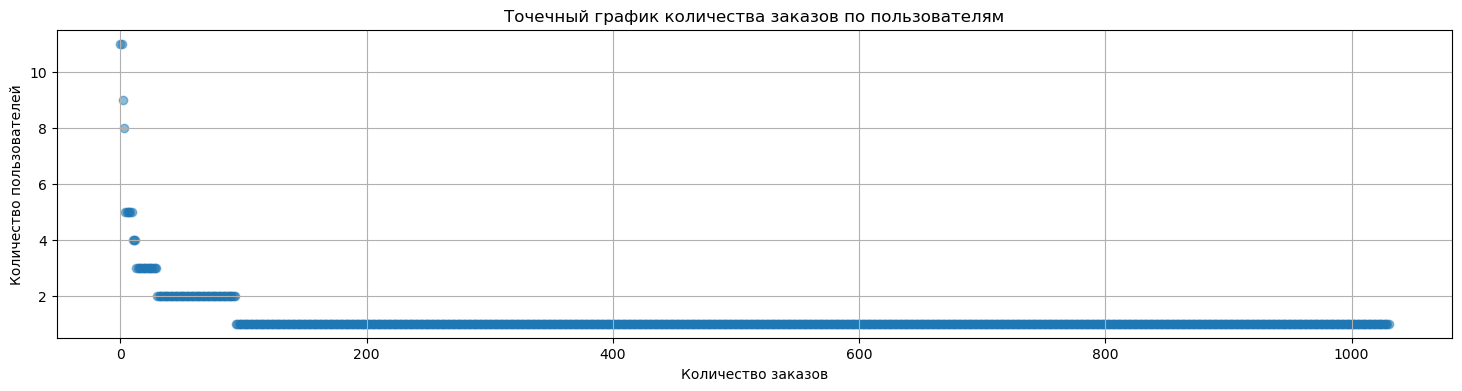

In [30]:
# зададим размер графика
plt.figure(figsize=(18,4))
plt.grid()
x_values = pd.Series(range(0,len(purchase)))
plt.title('Точечный график количества заказов по пользователям')
plt.ylabel('Количество пользователей')
plt.xlabel('Количество заказов')
plt.scatter(x_values, purchase['transaction_id'], alpha=0.5, ) ;

In [31]:
purchase.groupby('transaction_id')['visitor_id'].count()

transaction_id
1     937
2      64
3      17
4       3
5       6
8       1
9       1
11      2
Name: visitor_id, dtype: int64

В основном, один посетитель совершил один заказ. Незначительное число тех, кто совершил 2 или 3 заказа. 4 и более заказов - единичные случаи.

### 2.7 Посчитайте 95-й и 99-й перцентили количества заказов на пользователя. Выберите границу для определения аномальных пользователей.

In [32]:
print(np.percentile(purchase['transaction_id'], [90, 95, 97, 98, 99])) 

[1. 2. 2. 3. 4.]


Большинство пользователей делают один, в редких случаях два заказа. Возьмём percentile 98, три и более заказов исключим, как аномальные.

### 2.8 Постройте точечный график стоимостей заказов. Сделайте выводы и предположения.

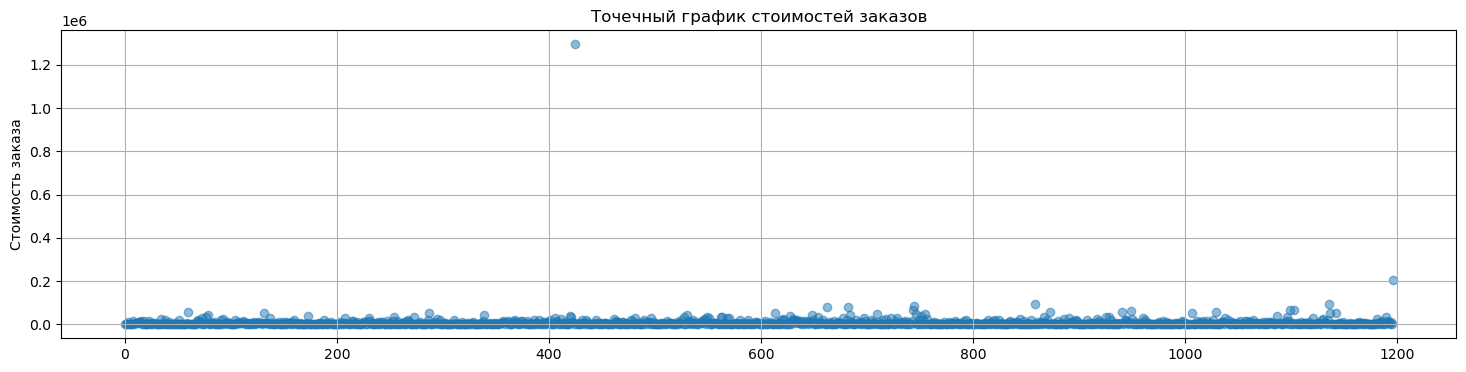

In [33]:
# зададим размер графика
plt.figure(figsize=(18,4))
x_values = pd.Series(range(0,len(orders['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.scatter(x_values, orders['revenue'], alpha=.5) ;

Ранее метод describe показал, что стоимость большинства заказов не превышает 9 000. График демонстрирует наличие двух аномальных платежей.

### 2.9 Посчитайте 95-й и 99-й перцентили стоимости заказов. Выберите границу для определения аномальных заказов.

In [34]:
print(np.percentile(orders['revenue'], [90, 95, 97, 98, 99])) 

[18168.  28000.  35485.  44133.2 58233.2]


Не более 5% заказов дороже 28 000 рублей и не более 1% дороже 58 233.   
для определения верхней границы, повторно построим точечный график, исключив выбросы.

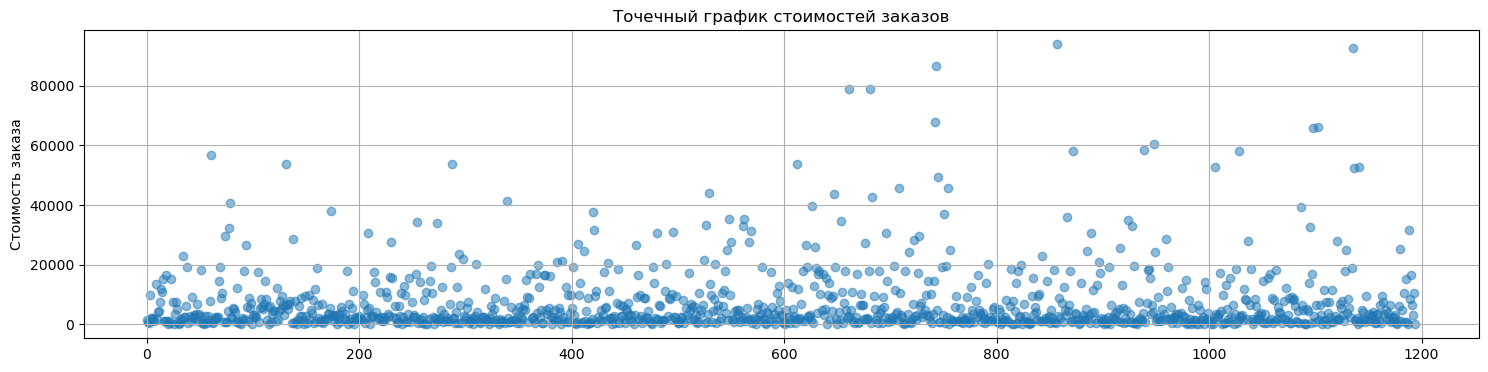

In [35]:
# создадим переменную с заказами стоимостью до 199000
orders_tmp = orders.query('revenue < 199000')

#norm_orders = orders[orders['revenue']<=195000]['revenue']
plt.figure(figsize=(18,4))
x_values = pd.Series(range(0,len(orders_tmp['revenue'])))
plt.title('Точечный график стоимостей заказов')
plt.ylabel('Стоимость заказа')
plt.grid()
plt.scatter(x_values, orders_tmp['revenue'], alpha=.5) ;

Т.к. принято отсеивать от 1% до 5% наблюдений с крайними значениями, установлю верхнею границу платежа - 98 перцентиль в 45 тыс. 

### 2.10 Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «сырым» данным. Сделайте выводы и предположения.

In [36]:
visitorsADaily = visitors[visitors['group'] == 'A'][['date', 'visitors']]
visitorsADaily.columns = ['date', 'visitorsPerDateA']

visitorsACummulative = visitorsADaily.apply(
    lambda x: visitorsADaily[visitorsADaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateA': 'sum'}
    ),
    axis=1,
)
visitorsACummulative.columns = ['date', 'visitorsCummulativeA']

visitorsBDaily = visitors[visitors['group'] == 'B'][['date', 'visitors']]
visitorsBDaily.columns = ['date', 'visitorsPerDateB']

visitorsBCummulative = visitorsBDaily.apply(
    lambda x: visitorsBDaily[visitorsBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'visitorsPerDateB': 'sum'}
    ),
    axis=1,
)
visitorsBCummulative.columns = ['date', 'visitorsCummulativeB']

ordersADaily = (
    orders[orders['group'] == 'A'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersADaily.columns = ['date', 'ordersPerDateA', 'revenuePerDateA']

ordersACummulative = ordersADaily.apply(
    lambda x: ordersADaily[ordersADaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateA': 'sum', 'revenuePerDateA': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersACummulative.columns = [
    'date',
    'ordersCummulativeA',
    'revenueCummulativeA',
]

ordersBDaily = (
    orders[orders['group'] == 'B'][['date', 'transaction_id', 'visitor_id', 'revenue']]
    .groupby('date', as_index=False)
    .agg({'transaction_id': pd.Series.nunique, 'revenue': 'sum'})
)
ordersBDaily.columns = ['date', 'ordersPerDateB', 'revenuePerDateB']

ordersBCummulative = ordersBDaily.apply(
    lambda x: ordersBDaily[ordersBDaily['date'] <= x['date']].agg(
        {'date': 'max', 'ordersPerDateB': 'sum', 'revenuePerDateB': 'sum'}
    ),
    axis=1,
).sort_values(by=['date'])
ordersBCummulative.columns = [
    'date',
    'ordersCummulativeB',
    'revenueCummulativeB',
]

data = (
    ordersADaily.merge(
        ordersBDaily, left_on='date', right_on='date', how='left'
    )
    .merge(ordersACummulative, left_on='date', right_on='date', how='left')
    .merge(ordersBCummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsADaily, left_on='date', right_on='date', how='left')
    .merge(visitorsBDaily, left_on='date', right_on='date', how='left')
    .merge(visitorsACummulative, left_on='date', right_on='date', how='left')
    .merge(visitorsBCummulative, left_on='date', right_on='date', how='left')
)

print(data.head(5)) 

        date  ordersPerDateA  revenuePerDateA  ordersPerDateB  \
0 2019-08-01              24           148579              21   
1 2019-08-02              20            93822              24   
2 2019-08-03              24           112473              16   
3 2019-08-04              16            70825              17   
4 2019-08-05              25           124218              23   

   revenuePerDateB  ordersCummulativeA  revenueCummulativeA  \
0           101217                  24               148579   
1           165531                  44               242401   
2           114248                  68               354874   
3           108571                  84               425699   
4            92428                 109               549917   

   ordersCummulativeB  revenueCummulativeB  visitorsPerDateA  \
0                  21               101217               719   
1                  45               266748               619   
2                  61               38

Содержание таблицы:
- `date` — дата;
- `ordersPerDateA` — количество заказов в выбранную дату в группе A;
- `revenuePerDateA` — суммарная выручка в выбранную дату в группе A;
- `ordersPerDateB` — количество заказов в выбранную дату в группе B;
- `revenuePerDateB` — суммарная выручка в выбранную дату в группе B;
- `ordersCummulativeA` — суммарное число заказов до выбранной даты включительно в группе A;
- `revenueCummulativeA` — суммарная выручка до выбранной даты включительно в группе A;
- `ordersCummulativeB` — суммарное количество заказов до выбранной даты включительно в группе B;
- `revenueCummulativeB` — суммарная выручка до выбранной даты включительно в группе B;
- `visitorsPerDateA` — количество пользователей в выбранную дату в группе A;
- `visitorsPerDateB` — количество пользователей в выбранную дату в группе B;
- `visitorsCummulativeA` — количество пользователей до выбранной даты включительно в группе A;
- `visitorsCummulativeB` — количество пользователей до выбранной даты включительно в группе B.

Посчитаем статистическую значимость различия в среднем количестве заказов между группами.   

**Сформулируем гипотезы.**

- Нулевая: различий в среднем количестве заказов между группами нет. 
- Альтернативная: различия в среднем количестве заказов между группами есть.

In [37]:
# Создадим переменные ordersByUsersA и ordersByUsersB со столбцами ['userId', 'orders']. 
# В них для пользователей, которые заказывали хотя бы 1 раз, укажем число совершённых заказов. 
ordersByUsersA = (
    orders[orders['group'] == 'A']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersA.columns = ['userId', 'orders']

ordersByUsersB = (
    orders[orders['group'] == 'B']
    .groupby('visitor_id', as_index=False)
    .agg({'transaction_id': pd.Series.nunique})
)
ordersByUsersB.columns = ['userId', 'orders']

# Объявим переменные sampleA и sampleB, в которых пользователям из разных групп будет соответствовать количество заказов.
# Тем, кто ничего не заказал, будут соответствовать нули.
sampleA = pd.concat(
    [
        ordersByUsersA['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleB = pd.concat(
    [
        ordersByUsersB['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

# Применим критерий и отформатируем p-value, округлив его до трёх знаков после запятой.
print("p-value = {0:.3f}".format(stats.mannwhitneyu(sampleA, sampleB)[1]))

print("Относительный прирост среднего числа заказов группы B = {0:.3f}".format(sampleB.mean() / sampleA.mean() - 1))

p-value = 0.017
Относительный прирост среднего числа заказов группы B = 0.138


p-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет, отвергаем. Значит по «сырым» данным есть различия в среднем количестве заказов между группами.   
Относительный выигрыш группы **B** равен 13.8%.

### 2.11 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «сырым» данным. Сделайте выводы и предположения.

Нулевая гипотеза: различий в среднем чеке между группами нет. Альтернативная гипотеза: различия в среднем чеке между группами есть. 

Чтобы рассчитать статистическую значимость различий в среднем чеке, передадим критерию `mannwhitneyu()` данные о выручке с заказов. 

In [38]:
# найдём относительные различия в среднем чеке между группами:
print('p-value = {0:.3f}'
      .format(stats.mannwhitneyu(orders[orders['group']=='A']['revenue'], orders[orders['group']=='B']['revenue'])[1]))
print('Относительные различия = {0:.3f}'
      .format(orders[orders['group']=='B']['revenue'].mean()/orders[orders['group']=='A']['revenue'].mean()-1)) 

p-value = 0.729
Относительные различия = 0.259


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.   
Средний чек группы **B** выше среднего чека группы **A** на 26%.

Вероятно, из-за аномальных выбросов в группе **В** тест не показал, что разница в 26% не является статистически значимой.

### 2.12 Посчитайте статистическую значимость различий в среднем количестве заказов между группами по «очищенным» данным. Сделайте выводы и предположения.

Сделаем срезы пользователей с числом заказов больше 2 — `usersWithManyOrders` и пользователей, совершивших заказы дороже 45 000 — `usersWithExpensiveOrders`. Объединим их в таблице `abnormalUsers`.

In [39]:
usersWithManyOrders = pd.concat(
    [
        ordersByUsersA[ordersByUsersA['orders'] > np.percentile(purchase['transaction_id'], [95, 98])[1]]['userId'],
        ordersByUsersB[ordersByUsersB['orders'] > np.percentile(purchase['transaction_id'], [95, 98])[1]]['userId'],
    ],
    axis=0,
)
usersWithExpensiveOrders = orders[orders['revenue'] > np.percentile(orders['revenue'], [95, 98])[1]]['visitor_id']
abnormalUsers = (
    pd.concat([usersWithManyOrders, usersWithExpensiveOrders], axis=0)
    .drop_duplicates()
    .sort_values()
)
print(abnormalUsers.head(5))
print()
print('Количество аномальных пользователей =', abnormalUsers.shape[0])

1099    148427295
18      199603092
23      237748145
1137    759473111
949     887908475
dtype: int64

Количество аномальных пользователей = 29


Узнаем, как их действия повлияли на результаты теста. Посчитаем статистическую значимость различий в среднем количестве заказов между группами теста по очищенным данным. Сначала подготовим выборки количества заказов по пользователям по группам теста:

**Сформулируем гипотезы.**

- Нулевая: различий в среднем количестве заказов между группами нет. 
- Альтернативная: различия в среднем количестве заказов между группами есть.

In [40]:
sampleAFiltered = pd.concat(
    [
        ordersByUsersA[
            np.logical_not(ordersByUsersA['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateA'].sum() - len(ordersByUsersA['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)

sampleBFiltered = pd.concat(
    [
        ordersByUsersB[
            np.logical_not(ordersByUsersB['userId'].isin(abnormalUsers))
        ]['orders'],
        pd.Series(
            0,
            index=np.arange(
                data['visitorsPerDateB'].sum() - len(ordersByUsersB['orders'])
            ),
            name='orders',
        ),
    ],
    axis=0,
)    

Применим статистический критерий Манна-Уитни к полученным выборкам:

In [41]:
print('p-value = {0:.3f}'.format(stats.mannwhitneyu(sampleAFiltered, sampleBFiltered)[1]))
print('Относительный прирост среднего числа заказов группы B = {0:.3f}' \
      .format(sampleBFiltered.mean()/sampleAFiltered.mean()-1)) 

p-value = 0.010
Относительный прирост среднего числа заказов группы B = 0.161


p-value меньше 0.05. Значит, нулевую гипотезу о том, что статистически значимых различий в среднем числе заказов между группами нет. отвергаем. Значит по «очищенным», как и по «сырым» есть различия в среднем количестве заказов между группами.   
Относительный выигрыш группы **B** равен 18.5%. По «сырым» данным выигрыш - 13.8%

Результаты по среднему количеству заказов практически не изменились. Произошло ли что-нибудь с результатами по среднему чеку?

### 2.12 Посчитайте статистическую значимость различий в среднем чеке заказа между группами по «очищенным» данным. Сделайте выводы и предположения.

**Сформулируем гипотезы.**
- Нулевая гипотеза: различий в среднем чеке между группами нет. 
- Альтернативная гипотеза: различия в среднем чеке между группами есть. 



In [42]:
print(
    'p-value = {0:.3f}'.format(
        stats.mannwhitneyu(
            orders[
                np.logical_and(
                    orders['group'] == 'A',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
            orders[
                np.logical_and(
                    orders['group'] == 'B',
                    np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
                )
            ]['revenue'],
        )[1]
    )
)

print(
    "Относительные различия = {0:.3f}".format(
        orders[
            np.logical_and(
                orders['group'] == 'B',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        / orders[
            np.logical_and(
                orders['group'] == 'A',
                np.logical_not(orders['visitor_id'].isin(abnormalUsers)),
            )
        ]['revenue'].mean()
        - 1
    )
) 

p-value = 0.768
Относительные различия = 0.041


P-value значительно больше 0.05. Значит, причин отвергать нулевую гипотезу и считать, что в среднем чеке есть различия, нет.

После исключения самых дорогих заказов средний чек группы **B** стал еще выше среднего чека группы A на 3,7%, против 26% «сырым» данным.

### 2.14 Примите решение по результатам теста и объясните его. Варианты решений: 1. Остановить тест, зафиксировать победу одной из групп. 2. Остановить тест, зафиксировать отсутствие различий между группами. 3. Продолжить тест.

**Вывод:**   
Статистическая значимость различий в среднем количестве заказов между группами по «сырым» и «очищенным» данным **есть**.  

P-value по «сырым» данным = 0.017   
P-value по «очищенным» данным = 0.007

Относительный прирост среднего числа заказов группы **B** по «сырым» данным = 13.8%   
Относительный прирост среднего числа заказов группы **B** по «очищенным» данным = 18.5%   

========================================================================================     
 
Статистическая значимость различий в среднем чеке заказа между группами по «сырым» и «очищенным» данным **отсутствует**.    

P-value по «сырым» данным = 0.729   
P-value по «очищенным» данным = 0.994


Относительные различия по «сырым» данным = 26%   
Относительные различия по «очищенным» данным = 3,7%   

Есть статистически значимые различия по среднему количеству заказов между группами как по «сырым», так и по данным после фильтрации аномалий;   
Отсутствуют статистически значимого различия по среднему чеку между группами ни по «сырым», ни по данным после фильтрации аномалий;

- График различия конверсии между группами демонстрирует преимущество группы **В** над группой **А**
- График различия среднего чека показывает хорошие результаты группы **В**



Исходя из обнаруженных фактов, тест следует остановить и признать его успешным. Показатели группы **В** лучше.